# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. 

Имеется набор фотографий людей с указанием возраста.

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузка данных из датафрейма и папки:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Обзор данных:

In [3]:
display(labels.head())
print('--------------------------------------')
print('Размер:')
print(labels.shape)
print('--------------------------------------')
print('Информация:')
print(labels.info())
print('--------------------------------------')
print('Дубликаты:')
print(labels.duplicated().sum())
print('--------------------------------------')
print('Пропуски:')
print(labels.isna().sum())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


--------------------------------------
Размер:
(7591, 2)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
file_name    0
real_age     0
dtype: int64


Пропусков нет, дубликатов нет, типы данных соответствуют необходимым, названия столбцов в "змеином" регистре.

Данные готовы к работе модели.

### Исследовательский анализ данных

Исследуем распределение возрастов в имеющихся данных:

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Среднее - 31 год, медиана - 29 лет. Распределение смещено незначительно.

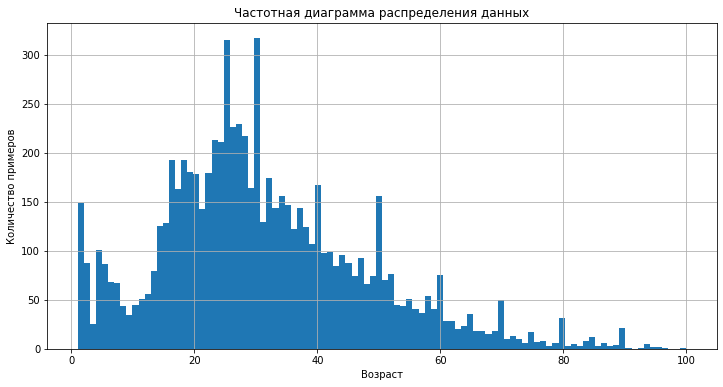

In [5]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(labels['real_age'],
                            max(labels['real_age'])-min(labels['real_age'])+1)
plt.xlabel('Возраст')
plt.ylabel('Количество примеров')
plt.title('Частотная диаграмма распределения данных')
plt.grid(True)
plt.show()

Частотная гистограмма напоминает распределение Пуассона с некоторыми пиками вначале и в районе самых часто встречающихся значений возраста. Мало данных в районе 15 лет, что может негативно сказаться на качестве обучения, ведь для одной из целей исследования нужно исследовать именно этот возраст (18 лет и меньше). Также довольно мало данных после 60 лет.

In [6]:
features, target = next(train_gen_flow)

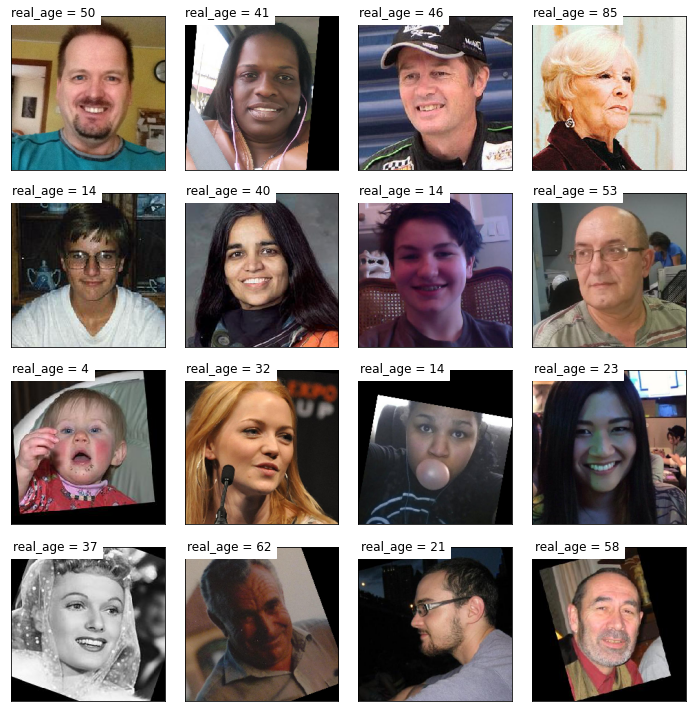

In [7]:
# выводим 16 изображений с подписями
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text((i//4), (i//4), 
             "real_age = " + str(target[i]), 
             backgroundcolor = 'white', 
             fontsize = 'large')
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Некоторые лица повёрнуты так, чтобы ось симметрии лица была вертикальной. Это упрощает задачу модели, а реальные люди в магазине могут быть расположены иначе.

Добавим в модель аугментации - поворот на 20 градусов и отражение по горизонтали.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                        rescale = 1./255, 
                                        horizontal_flip=True,
                                        rotation_range = 20)

    labels = pd.read_csv(path + '/labels.csv')

    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + '/final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_data


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)

    labels = pd.read_csv(path + '/labels.csv')

    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + '/final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data  


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(0.0001)
    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=['mean_absolute_error'])
    model.summary()             # вывод параметров модели
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

Результат обучения модели:


```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
=================================================================
Total params: 23,792,713
Trainable params: 23,739,593
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Epoch 1/10
Train for 178 steps, validate for 60 steps

178/178 - 100s - loss: 218.8674 - mean_absolute_error: 10.8280 - val_loss: 624.5539 - val_mean_absolute_error: 20.0167
Epoch 2/10
178/178 - 92s - loss: 91.5552 - mean_absolute_error: 7.2771 - val_loss: 558.1625 - val_mean_absolute_error: 18.3398
Epoch 3/10
Epoch 4/10
178/178 - 92s - loss: 71.1658 - mean_absolute_error: 6.4068 - val_loss: 286.7289 - val_mean_absolute_error: 12.2662
178/178 - 92s - loss: 53.9109 - mean_absolute_error: 5.6174 - val_loss: 131.3030 - val_mean_absolute_error: 8.6264
Epoch 5/10
178/178 - 93s - loss: 45.8697 - mean_absolute_error: 5.1288 - val_loss: 86.0665 - val_mean_absolute_error: 6.9684
Epoch 6/10
178/178 - 92s - loss: 38.0494 - mean_absolute_error: 4.7518 - val_loss: 85.0236 - val_mean_absolute_error: 6.8307
Epoch 7/10
178/178 - 91s - loss: 31.5213 - mean_absolute_error: 4.3013 - val_loss: 72.5978 - val_mean_absolute_error: 6.4615
Epoch 8/10
178/178 - 91s - loss: 27.0782 - mean_absolute_error: 4.0157 - val_loss: 77.1081 - val_mean_absolute_error: 6.4612
Epoch 9/10
178/178 - 92s - loss: 23.2807 - mean_absolute_error: 3.6892 - val_loss: 75.2672 - val_mean_absolute_error: 6.3374
Epoch 10/10
178/178 - 92s - loss: 21.1105 - mean_absolute_error: 3.5133 - val_loss: 73.3564 - val_mean_absolute_error: 6.2852

60/60 - 10s - loss: 73.3564 - mean_absolute_error: 6.2852
Test MAE: 6.2852
```

## Анализ обученной модели

Модель предсказания возраста покупателя на основе архитектуры ResNet50 успешно достигла необходимой точности - средняя абсолютная ошибка по итогам обучения составила 6.2852 года. 

Корень из среднеквадратической ошибки составил 8,56. RMSE более чувствителен к выбросам, чем MAE, возможно, в модели есть "слабые места", связанные с недостатком данных в некоторых возрастных категориях.


Достигнутое значение средней абсолютной ошибки позволит:
- Эффективнее рекомендовать товары, подходящие клиентам
- Следить за соблюдением закона при продаже товаров, разрешенных для покупателей старше 18 лет.

Необходимая точность была достигнута уже после пяти эпох обучения. При необходимости можно ускорить обучение, несколько потеряв в точности предсказания. 